## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import dataset_modules.preloaded_one_part_dataset as popd
import dataset_modules.image_preloader as image_preloader
import metrics_helper
import main

importlib.reload(main)
importlib.reload(popd)

<module 'dataset_modules.preloaded_one_part_dataset' from '/clusteruy/home/franco.cuevas/tesis-jupyters-2/dataset_modules/preloaded_one_part_dataset.py'>

## Variables

In [ ]:
part = "Paragolpe Delantero"
FEATURE_EXTRACTION = False

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

In [3]:
# preload images
preloaded_images = image_preloader.preload_images(
        images_folder='./dataset_modules/imgs/', 
        state_file='./dataset_modules/state.json', 
        resize_to=224
)

Started to preload images...
Image preloading complete in 2m 10s
The preloaded images use 0.07039642333984375MB of memory


## Pick transformations and see how they look

----- CLASS DISTRIBUTION -----
Class: paragolpe_delantero_sano, #475, 63.42%
Class: paragolpe_delantero_roto, #274, 36.58%


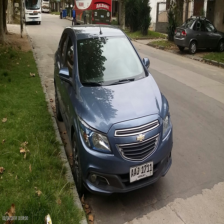

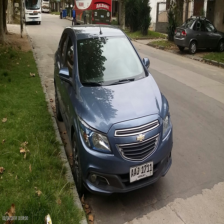

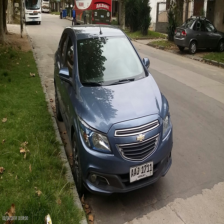

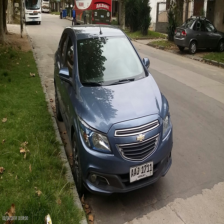

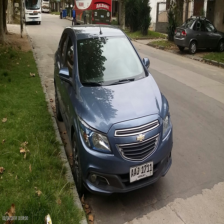

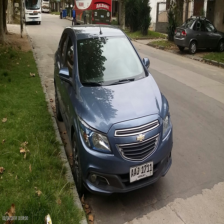

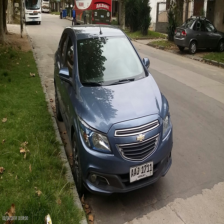

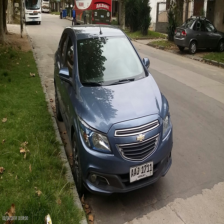

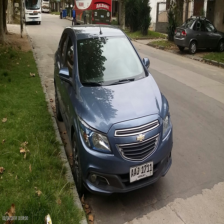

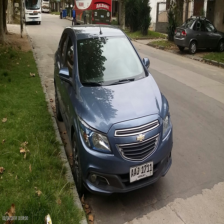

749
tensor([1.3668, 0.7884])


In [28]:
import sklearn

data_augmentation=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Compose([transforms.RandomEqualize()]),
        #transforms.RandomRotation((-20, 20))
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.RandomApply([transforms.RandomRotation((-20, 20))], p=0.2),
        #transforms.RandomEqualize(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation((-45, 45))
    ])

dataset = popd.PreloadedOnePartDataset(
    part,
    preloaded_images,
    data_augmentation=data_augmentation,
    class_to_augment=0,
    remove_not_visible=True,
    visibility_file="./dataset_modules/analisis_manual_paragolpe.csv"
)

for i in range(10):
    display(dataset[0][0])
    
print(len(dataset.samples))

y = [y_s for (_,y_s,_) in dataset.samples]
balanced_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=[0,1], y=y)
balanced_weights = torch.tensor(balanced_weights,dtype=torch.float)
print(balanced_weights)

## Train model

In [ ]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-augment"

main.train_one_part_model_dataugment(
    part, 
    preloaded_images, 
    MODEL_NAME, 
    EXPERIMENT_NAME, 
    device, 
    feature_extraction=False,
    train_ratio=0.8,
    random_state=42,
    num_epochs=40,
    data_augmentation=data_augmentation,
    remove_not_visible=True,
    class_to_augment=0,
    visibility_file="./dataset_modules/analisis_manual_paragolpe.csv",
    class_weights=balanced_weights
)

LOAD TRAIN
----- CLASS DISTRIBUTION -----
Class: paragolpe_delantero_sano, #386, 63.07%
Class: paragolpe_delantero_roto, #226, 36.93%
LOAD TEST
----- CLASS DISTRIBUTION -----
Class: paragolpe_delantero_sano, #89, 64.96%
Class: paragolpe_delantero_roto, #48, 35.04%
#TRAIN 612 #TEST 137
Epoch 0/39
----------
train Loss: 0.6877 Main metric (macro_f1): 0.5614 Time: 4.53s
test Loss: 0.6739 Main metric (macro_f1): 0.4624 Time: 0.45s
Epoch 1/39
----------
train Loss: 0.6656 Main metric (macro_f1): 0.5923 Time: 4.47s
test Loss: 0.6628 Main metric (macro_f1): 0.4836 Time: 0.45s
ES Module Best: 0.6628203409431624, BadEpochs: 0
Epoch 2/39
----------
train Loss: 0.6414 Main metric (macro_f1): 0.6287 Time: 4.49s
test Loss: 0.6444 Main metric (macro_f1): 0.6162 Time: 0.46s
ES Module Best: 0.6443971073540458, BadEpochs: 0
Epoch 3/39
----------
train Loss: 0.6157 Main metric (macro_f1): 0.7099 Time: 4.49s
test Loss: 0.6310 Main metric (macro_f1): 0.6249 Time: 0.45s
ES Module Best: 0.631028787062986, B

LOAD TRAIN
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #720, 54.05%
Class: paragolpe_delantero_sano, #363, 27.25%
Class: paragolpe_delantero_roto, #249, 18.69%
LOAD TEST
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #196, 58.86%
Class: paragolpe_delantero_sano, #80, 24.02%
Class: paragolpe_delantero_roto, #57, 17.12%
#TRAIN 1332 #TEST 333
Epoch 0/39
----------
train Loss: 0.9316 Main metric (macro_f1): 0.2770 Time: 9.78s
test Loss: 0.8032 Main metric (macro_f1): 0.4392 Time: 1.07s
Epoch 1/39
----------
train Loss: 0.7885 Main metric (macro_f1): 0.4366 Time: 9.78s
test Loss: 0.6637 Main metric (macro_f1): 0.5963 Time: 1.07s
ES Module Best: 0.6637179536504431, BadEpochs: 0
Epoch 2/39
----------
train Loss: 0.6675 Main metric (macro_f1): 0.5697 Time: 9.81s
test Loss: 0.5513 Main metric (macro_f1): 0.5884 Time: 1.09s
ES Module Best: 0.5512678946281696, BadEpochs: 0
Epoch 3/39
----------
train Loss: 0.5744 Main metric (macro_f1): 0.5935 Time: 9.83s
test Los

,class,precision,recall,f1
0,paragolpe_delantero_roto,0.685185,0.649123,0.666667
1,paragolpe_delantero_sano,0.744186,0.800000,0.771084
2,no_paragolpe_delantero,0.989637,0.974490,0.982005


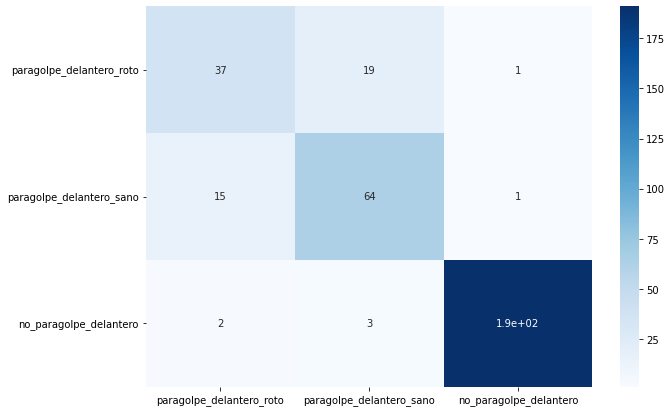

In [12]:
data_augmentation=transforms.Compose([
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.Compose([transforms.RandomEqualize()]),
        #transforms.RandomRotation((-20, 20))
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.RandomApply([transforms.RandomRotation((-20, 20))], p=0.2),
        #transforms.RandomEqualize(),
        transforms.RandomHorizontalFlip(p=0.5),
    ])

MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-augment-2"

main.train_one_part_model_dataugment(
    part, 
    preloaded_images, 
    MODEL_NAME, 
    EXPERIMENT_NAME, 
    device, 
    feature_extraction=False,
    train_ratio=0.8,
    random_state=42,
    num_epochs=40,
    ignore_repair=True,
    data_augmentation=data_augmentation
)

LOAD TRAIN
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #720, 54.05%
Class: paragolpe_delantero_sano, #363, 27.25%
Class: paragolpe_delantero_roto, #249, 18.69%
LOAD TEST
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #196, 58.86%
Class: paragolpe_delantero_sano, #80, 24.02%
Class: paragolpe_delantero_roto, #57, 17.12%
#TRAIN 1332 #TEST 333
Epoch 0/39
----------
train Loss: 0.9728 Main metric (macro_f1): 0.2769 Time: 10.00s
test Loss: 0.8569 Main metric (macro_f1): 0.2557 Time: 1.07s
Epoch 1/39
----------
train Loss: 0.8713 Main metric (macro_f1): 0.3215 Time: 9.99s
test Loss: 0.7688 Main metric (macro_f1): 0.4846 Time: 1.06s
ES Module Best: 0.7688058466166705, BadEpochs: 0
Epoch 2/39
----------
train Loss: 0.7774 Main metric (macro_f1): 0.4760 Time: 10.01s
test Loss: 0.6575 Main metric (macro_f1): 0.4975 Time: 1.06s
ES Module Best: 0.6574523393456284, BadEpochs: 0
Epoch 3/39
----------
train Loss: 0.6874 Main metric (macro_f1): 0.5341 Time: 10.03s
test 

,class,precision,recall,f1
0,paragolpe_delantero_roto,0.766667,0.403509,0.528736
1,paragolpe_delantero_sano,0.663551,0.887500,0.759358
2,no_paragolpe_delantero,0.979592,0.979592,0.979592


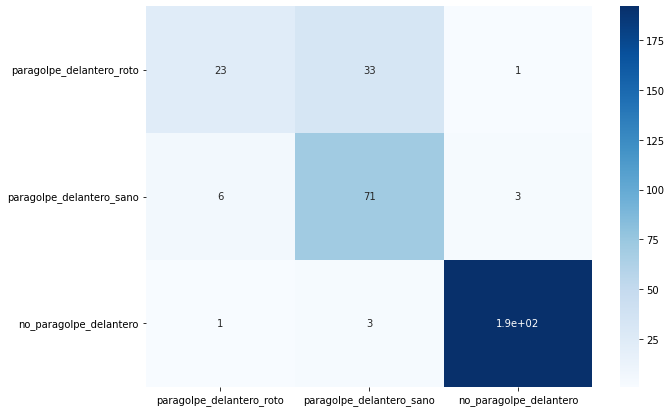

In [14]:
data_augmentation=transforms.Compose([
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.Compose([transforms.RandomEqualize()]),
        transforms.RandomRotation((-45, 45))
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.RandomApply([transforms.RandomRotation((-20, 20))], p=0.2),
        #transforms.RandomEqualize(),
        #transforms.RandomHorizontalFlip(p=0.5),
    ])

MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-augment-3"

main.train_one_part_model_dataugment(
    part, 
    preloaded_images, 
    MODEL_NAME, 
    EXPERIMENT_NAME, 
    device, 
    feature_extraction=False,
    train_ratio=0.8,
    random_state=42,
    num_epochs=40,
    ignore_repair=True,
    data_augmentation=data_augmentation
)